### Описание задачи

Из нейросети получены данные о заруженности в виде количества машин на кокретном перекрестке.

Исходные данные - дата,число машин, данные погоде в виде температуры

Задача спрогнозировать количество траффика в нужный момент времени

### Импорты

In [ ]:
# pip install ephem

In [102]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
import ephem
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

### Получение данных

In [103]:


# Set the desired date range
start_date = '2023-01-01'
end_date = '2023-06-16'

# Generate a date range with hourly frequency
date_range = pd.date_range(start=start_date, end=end_date, freq='H')


# Generate data with higher car counts during peak hours on working days
data = {
    'date': date_range,
    'number_of_cars': [
        np.random.randint(50, 100) if ((date.hour  in range(7,10) or date.hour in range (17,20)) and date.weekday() <6) else np.random.randint(0, 50)
        for date in date_range
    ]
}

df = pd.DataFrame(data)

# Convert the 'date' column to datetime index
df.set_index('date', inplace=True)




### Вспомогательные функции

In [190]:

def generate_temperature(date):
    observer = ephem.Observer()
    observer.lat = '45.0355'  # Latitude of Krasnodar, Russia
    observer.date = date

    sunrise = observer.previous_rising(ephem.Sun()).datetime()
    sunset = observer.next_setting(ephem.Sun()).datetime()

    temperature_range = {
        'spring': (-5, 20),    # Temperature range for spring
        'summer': (20, 35),    # Temperature range for summer
        'autumn': (5, 20),     # Temperature range for autumn
        'winter': (-5, 10)     # Temperature range for winter
    }

    if sunrise < date < sunset:  # Daytime temperature
        if 80 <= date.timetuple().tm_yday <= 171:  # Spring
            return np.random.randint(*temperature_range['spring'])
        elif 172 <= date.timetuple().tm_yday <= 264:  # Summer
            return np.random.randint(*temperature_range['summer'])
        elif 265 <= date.timetuple().tm_yday <= 355:  # Autumn
            return np.random.randint(*temperature_range['autumn'])
        else:  # Winter
            return np.random.randint(*temperature_range['winter'])
    else:  # Nighttime temperature
        return np.random.randint(-10, 5)  # Assume slightly colder temperature during nighttime
    
    

def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    cat_columns=['year','month','day','hour','dayofweek']
    for col in cat_columns:
        data[col]=data[col].astype('category')
    

    lag_cols = []
    new_data = pd.DataFrame()
    for i in range(1, max_lag + 1):
        column_name = "lag_" + str(i)
        new_data[column_name] = data['number_of_cars'].shift(i)
        lag_cols.append(column_name)
    
    data = pd.concat([data, new_data], axis=1)
    data['rolling_mean'] = data[lag_cols].rolling(rolling_mean_size).mean().values[:, -1]
    
    return data

# Add temperature column to the dataframe
df['temperature'] = [generate_temperature(date) for date in df.index]

### Анализ и визулизация данных

In [105]:
import matplotlib.pyplot as plt
from datetime import datetime

def plot_traffic_for_day(df, date_str):
    # Convert date string to datetime object
    date = datetime.strptime(date_str, '%Y-%m-%d')

    # Filter the dataframe for the given date
    day_data = df[df.index.date == date.date()]

    # Plotting code...
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(day_data.index, day_data['number_of_cars'], color='blue')
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Cars')
    ax.set_title(f'Traffic Data for {date.date()}')
    ax.grid(True)

    # Set the x-axis tick frequency to show hours

 
    # Rotate the x-axis tick labels for better readability
    plt.xticks(rotation=45)

    # Display the plot
    plt.show()

# Call the function with the correct date format



In [106]:
df

,number_of_cars,temperature
date,,
2023-01-01 00:00:00,5,-5
2023-01-01 01:00:00,15,7
2023-01-01 02:00:00,47,7
2023-01-01 03:00:00,0,5
2023-01-01 04:00:00,18,-4
...,...,...
2023-06-15 20:00:00,10,-5
2023-06-15 21:00:00,49,9
2023-06-15 22:00:00,39,7


График загрузки дороги, воскресенье


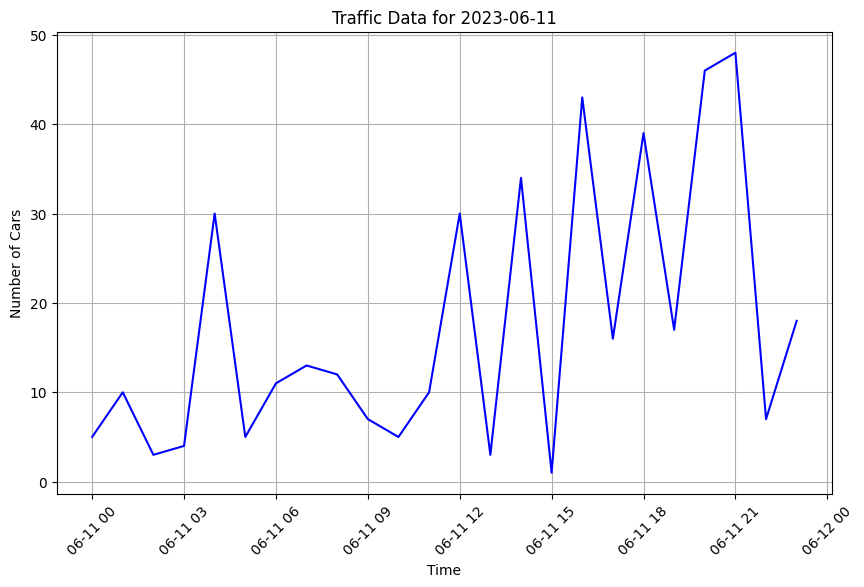

In [93]:
print('График загрузки дороги, воскресенье')
plot_traffic_for_day(df, '2023-06-11')

График загрузки дороги, понедельник


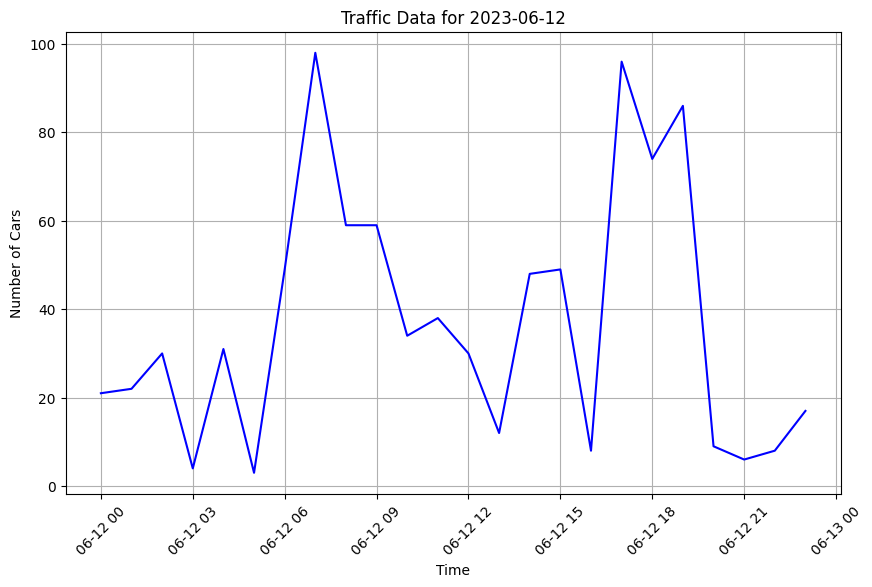

In [94]:
print('График загрузки дороги, понедельник')
plot_traffic_for_day(df, '2023-06-12')

График загрузки дороги, вторник


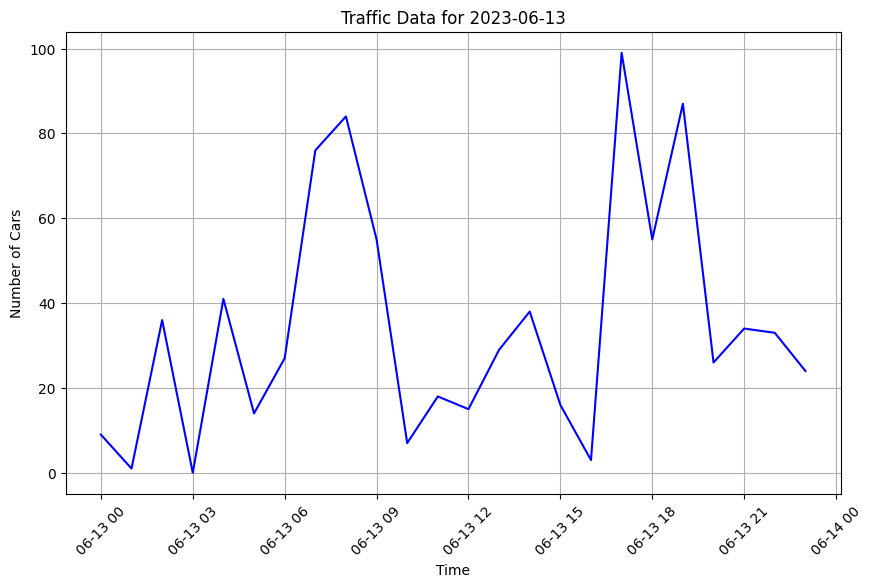

In [95]:
print('График загрузки дороги, вторник')
plot_traffic_for_day(df, '2023-06-13')

В течении рабочего дня наблюдается 2 пика:
- с 7 до 9 утра
- с 17 до 20 вечера

### Разделение выборки на тренировочную и тестовую

Применяем специальный сплит для временных рядов, чтобы не было утечки данных

In [96]:
tscv = TimeSeriesSplit(n_splits=5)
scoring_metric='neg_mean_squared_error'

### Машинное обучение


In [97]:
best_rmse = 60
lag = 0
window = 0



for i in range(5, 100, 5):
    for k in range(2, 50, 5):
        data = df.copy(deep=True)
        make_features(data, i, k)
        data = data.dropna()
        target = data['number_of_cars']
        features = data.drop(['number_of_cars'], axis=1)
        
        model_lin_regression = LinearRegression()
        scores = cross_val_score(model_lin_regression, features, target, cv=tscv, scoring=scoring_metric)
        rmse = np.sqrt(np.abs(np.mean(scores)))
        
        if rmse < best_rmse:
            best_rmse = rmse
            lag = i
            window = k

print('Best RMSE:', best_rmse)
print('Lag:', lag)
print('Window:', window)


Best RMSE: 24.92204235979654
Lag: 5
Window: 2


In [98]:


best_rmse = 60
lag = 0
window = 0

for i in range(5, 100, 5):
    for k in range(2, 50, 5):
        data = df.copy(deep=True)
        make_features(data, i, k)
        data = data.dropna()
        target = data['number_of_cars']
        features = data.drop(['number_of_cars'], axis=1)
        
        model_lgbm = lgb.LGBMRegressor()
        scores = cross_val_score(model_lgbm, features, target, cv=tscv, scoring=scoring_metric)
        rmse = np.sqrt(np.abs(np.mean(scores)))
        
        if rmse < best_rmse:
            best_rmse = rmse
            lag = i
            window = k

print('Best RMSE:', best_rmse)
print('Lag:', lag)
print('Window:', window)


Best RMSE: 15.410543993498433
Lag: 5
Window: 2


Сохраним модель

In [100]:
data = df.copy(deep=True)
make_features(data, lag, window)
data = data.dropna()
target = data[['number_of_cars']]
features = data.drop(['number_of_cars'], axis=1)
model_lgbm = lgb.LGBMRegressor()
model_lgbm.fit(features,target)

LGBMRegressor()

In [222]:
data

,date,temperature
0,2023-07-01,18


### Предсказания

In [107]:


np.random.seed(0)
temperatures = np.random.randint(10, 30, size=24)

# Create a DataFrame with the generated temperatures
data = pd.DataFrame({
    'temperature': temperatures
}, index=pd.date_range('2024-07-02 00:00:00', periods=24, freq='H'))

# Convert the index to datetime format
data.index = pd.to_datetime(data.index)

data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek

# Make predictions using your trained model

# Drop the 'number_of_cars' column from the new data
features = data

# Make predictions using your trained model
predictions = model_lgbm.predict(features)

# Add the predictions to the data DataFrame
data['predictions'] = predictions

data




,temperature,year,month,day,hour,dayofweek,predictions
2024-07-02 00:00:00,22,2024,7,2,0,1,24.878483
2024-07-02 01:00:00,25,2024,7,2,1,1,26.482592
2024-07-02 02:00:00,10,2024,7,2,2,1,20.142113
2024-07-02 03:00:00,13,2024,7,2,3,1,22.306830
2024-07-02 04:00:00,13,2024,7,2,4,1,25.776379
2024-07-02 05:00:00,17,2024,7,2,5,1,26.461700
2024-07-02 06:00:00,19,2024,7,2,6,1,32.833639
2024-07-02 07:00:00,29,2024,7,2,7,1,84.762284
2024-07-02 08:00:00,28,2024,7,2,8,1,78.879988
2024-07-02 09:00:00,14,2024,7,2,9,1,74.062424


### СОхраняем модель

In [244]:
import pickle


with open('traffic_forecast_model', 'wb') as f:
    pickle.dump(model_lgbm, f)


In [74]:
import pickle
with open('traffic_forecast_model', 'rb') as f:
    loaded_model = pickle.load(f)

In [228]:

np.random.seed(0)
temperatures = np.random.randint(10, 30, size=24)

# Create a DataFrame with the generated temperatures
data = pd.DataFrame({
    'temperature': temperatures
}, index=pd.date_range('2024-07-02 00:00:00', periods=24, freq='H'))
# display(data)

# # Convert the index to datetime format
# data.index = pd.to_datetime(data.index)

# display(data)

data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek

# Make predictions using your trained model

# Drop the 'number_of_cars' column from the new data
features = data

# Make predictions using your trained model
predictions = loaded_model.predict(features)

# Add the predictions to the data DataFrame
data['predictions'] = predictions

data



,temperature,year,month,day,hour,dayofweek,predictions
2024-07-02 00:00:00,22,2024,7,2,0,1,22.187373
2024-07-02 01:00:00,25,2024,7,2,1,1,25.065182
2024-07-02 02:00:00,10,2024,7,2,2,1,23.444851
2024-07-02 03:00:00,13,2024,7,2,3,1,27.069087
2024-07-02 04:00:00,13,2024,7,2,4,1,26.673440
2024-07-02 05:00:00,17,2024,7,2,5,1,27.003790
2024-07-02 06:00:00,19,2024,7,2,6,1,26.465845
2024-07-02 07:00:00,29,2024,7,2,7,1,76.726729
2024-07-02 08:00:00,28,2024,7,2,8,1,74.814938
2024-07-02 09:00:00,14,2024,7,2,9,1,77.443467


### Выводы

1. Можем улучшать качество модели за счет подбора гиперпараметров

2. Можем улучшать качество модели за счет добавления новых признаков

3. В дальнейшем при добавлении данных с других соседних перекрестков, мы можем использовать более сложные алгоритмы 

  Autoregressive Integrated Moving Average (ARIMA), 

  Seasonal ARIMA (SARIMA), 

  and Exponential Smoothing (ETS) models 


4. Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) networks, по мере добавления данных с новых перекрестков


5.Подключение api погоды 


# Прогнозирование износа дорог


Имея данные о проходимости 

https://rosavtodor.gov.ru/storage/app/media/uploaded-files/148odm-2183082-2016.pdf


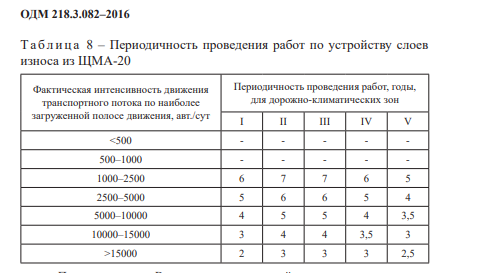


МЕТОДИЧЕСКИЕ РЕКОМЕНДАЦИИ
ПО НАЗНАЧЕНИЮ ТЕХНОЛОГИЙ
И ПЕРИОДИЧНОСТИ ПРОВЕДЕНИЯ
РАБОТ ПО УСТРОЙСТВУ СЛОЕВ ИЗНОСА
И ЗАЩИТНЫХ СЛОЕВ ДОРОЖНЫХ
ПОКРЫТИЙ

Согласно документу мы определяем количество трафика в сутки и если он выходит за категорию то сигналим

In [108]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 6, 16)
num_days = (end_date - start_date).days + 1

data = {
    'street': [],
    'date': [],
    'num_cars_daily': []
}

streets = ['перекресток Красная Северная',
           'перекресток Московская Солнечная',
           'перекресток Северная Школьная']

for day in range(num_days):
    date = start_date + timedelta(days=day)
    weekday = date.weekday()

    for street in streets:
        data['street'].append(street)
        data['date'].append(date)

        if weekday < 5:  # Weekday
            if street == 'перекресток Красная Северная':
                data['num_cars_daily'].append(np.random.randint(1000, 2501))
            elif street == 'перекресток Московская Солнечная':
                data['num_cars_daily'].append(np.random.randint(1000, 1301))
            elif street == 'перекресток Северная Школьная':
                data['num_cars_daily'].append(np.random.randint(1700, 2501))
                
        elif weekday == 5:  # Weekday
            if street == 'перекресток Красная Северная':
                data['num_cars_daily'].append(np.random.randint(1000, 2201))
            elif street == 'перекресток Московская Солнечная':
                data['num_cars_daily'].append(np.random.randint(1000, 1101))
            elif street == 'перекресток Северная Школьная':
                    data['num_cars_daily'].append(np.random.randint(1700, 2301))

        else:  # Weekend
            if street == 'перекресток Красная Северная':
                data['num_cars_daily'].append(np.random.randint(500, 1251))
            elif street == 'перекресток Московская Солнечная':
                data['num_cars_daily'].append(np.random.randint(500, 651))
            elif street == 'перекресток Северная Школьная':
                data['num_cars_daily'].append(np.random.randint(850, 1251))

df = pd.DataFrame(data)
display(df)


,street,date,num_cars_daily
0,перекресток Красная Северная,2023-01-01,1209
1,перекресток Московская Солнечная,2023-01-01,579
2,перекресток Северная Школьная,2023-01-01,1188
3,перекресток Красная Северная,2023-01-02,1099
4,перекресток Московская Солнечная,2023-01-02,1177
...,...,...,...
496,перекресток Московская Солнечная,2023-06-15,1022
497,перекресток Северная Школьная,2023-06-15,2160
498,перекресток Красная Северная,2023-06-16,1719
499,перекресток Московская Солнечная,2023-06-16,1090


#### угол Северной, Школьной

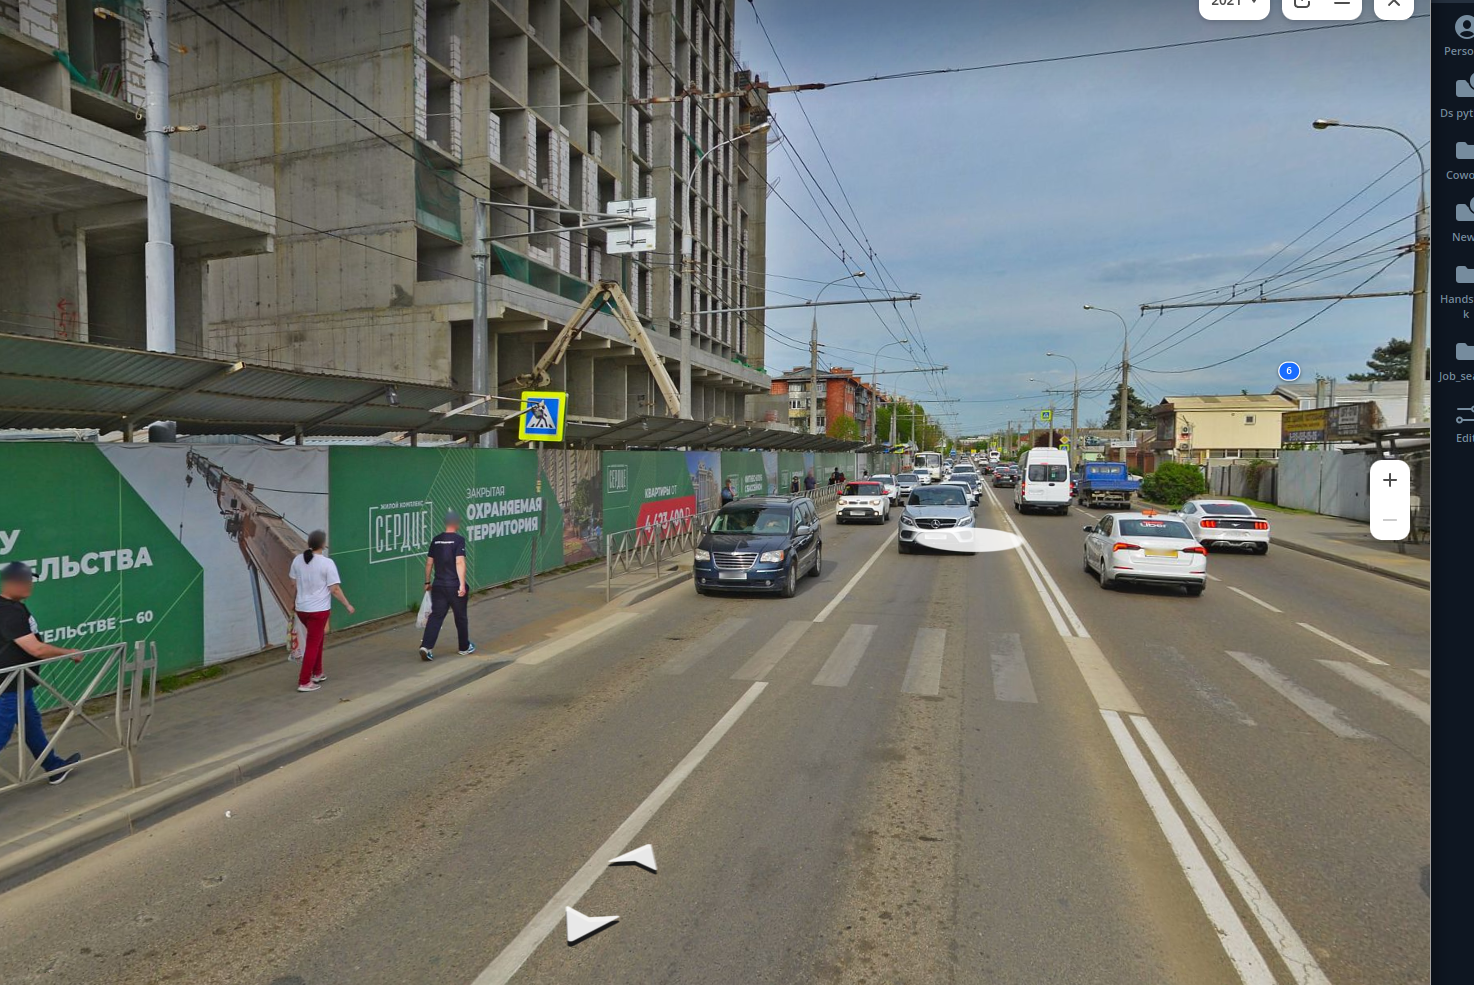

In [109]:


def plot_median_cars_by_weekday(df, street):
    df_street = df[df['street'] == street]

    # Group by weekday and calculate the median number of cars
    median_cars_by_weekday = df_street.groupby(df_street['date'].dt.weekday)['num_cars_daily'].median()

    # Create a list of weekday names
    weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Plot the median number of cars by weekday
    plt.plot(weekday_names, median_cars_by_weekday)
    plt.xlabel('Day of the Week')
    plt.ylabel('Median Number of Cars')
    plt.title(f'Median Number of Cars per Day - {street}')
    plt.show()


In [110]:


start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 6, 16)
num_days = (end_date - start_date).days + 1

data = {
    'street': [],
    'date': [],
    'num_cars_daily': []
}

streets = ['перекресток Красная Северная',
           'перекресток Московская Солнечная',
           'перекресток Северная Школьная']

for day in range(num_days):
    date = start_date + timedelta(days=day)
    month = date.month
    weekday = date.weekday()

    for street in streets:
        data['street'].append(street)
        data['date'].append(date)

        if weekday < 5:  # Weekday
            if street == 'перекресток Красная Северная':
                data['num_cars_daily'].append(np.random.randint(1000, 2501))
            elif street == 'перекресток Московская Солнечная':
                data['num_cars_daily'].append(np.random.randint(1000, 1301))
            elif street == 'перекресток Северная Школьная':
                if month in [3,4, 5, 6]:  # Higher range for March, May, June
                    data['num_cars_daily'].append(np.random.randint(2500, 5001))
                else:
                    data['num_cars_daily'].append(np.random.randint(1700, 2501))
                
        elif weekday == 5:  # Saturday
            if street == 'перекресток Красная Северная':
                data['num_cars_daily'].append(np.random.randint(1000, 2201))
            elif street == 'перекресток Московская Солнечная':
                data['num_cars_daily'].append(np.random.randint(1000, 1101))
            elif street == 'перекресток Северная Школьная':
                if month in [3,4 ,5, 6]:  # Higher range for March, May, June
                    data['num_cars_daily'].append(np.random.randint(2500, 5001))
                else:
                    data['num_cars_daily'].append(np.random.randint(1700, 2301))

        else:  # Sunday
            if street == 'перекресток Красная Северная':
                data['num_cars_daily'].append(np.random.randint(500, 1251))
            elif street == 'перекресток Московская Солнечная':
                data['num_cars_daily'].append(np.random.randint(500, 651))
            elif street == 'перекресток Северная Школьная':
                if month in [3,4 ,5, 6]:  # Higher range for March, May, June
                    data['num_cars_daily'].append(np.random.randint(2500, 5001))
                else:
                    data['num_cars_daily'].append(np.random.randint(850, 1251))

df = pd.DataFrame(data)
display(df)


,street,date,num_cars_daily
0,перекресток Красная Северная,2023-01-01,1220
1,перекресток Московская Солнечная,2023-01-01,561
2,перекресток Северная Школьная,2023-01-01,1153
3,перекресток Красная Северная,2023-01-02,1104
4,перекресток Московская Солнечная,2023-01-02,1128
...,...,...,...
496,перекресток Московская Солнечная,2023-06-15,1185
497,перекресток Северная Школьная,2023-06-15,3411
498,перекресток Красная Северная,2023-06-16,2351
499,перекресток Московская Солнечная,2023-06-16,1283


In [111]:
import pandas as pd

def assign_category(num_cars):
    if num_cars < 500:
        return "<500"
    elif num_cars < 1000:
        return "500-1000"
    elif num_cars < 2500:
        return "1000-2500"
    elif num_cars < 5000:
        return "2500-5000"
    elif num_cars < 10000:
        return "5000-10000"
    elif num_cars < 15000:
        return "10000-15000"
    else:
        return ">15000"

# Calculate average number of cars per month for each street
df['Month'] = df['date'].dt.month
df_avg_cars_per_month = df.groupby(['street', 'Month'])['num_cars_daily'].mean().reset_index()

# Assign category based on average number of cars
df_avg_cars_per_month['Category'] = df_avg_cars_per_month['num_cars_daily'].apply(assign_category)

display(df_avg_cars_per_month)


,street,Month,num_cars_daily,Category
0,перекресток Красная Северная,1,1586.806452,1000-2500
1,перекресток Красная Северная,2,1601.000000,1000-2500
2,перекресток Красная Северная,3,1472.870968,1000-2500
3,перекресток Красная Северная,4,1587.833333,1000-2500
4,перекресток Красная Северная,5,1711.870968,1000-2500
5,перекресток Красная Северная,6,1795.250000,1000-2500
6,перекресток Московская Солнечная,1,1059.612903,1000-2500
7,перекресток Московская Солнечная,2,1047.714286,1000-2500
8,перекресток Московская Солнечная,3,1050.354839,1000-2500
9,перекресток Московская Солнечная,4,1072.200000,1000-2500


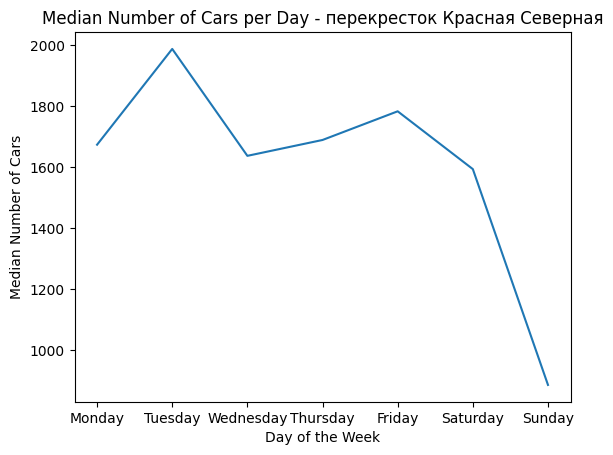

In [54]:
plot_median_cars_by_weekday(df, 'перекресток Красная Северная')

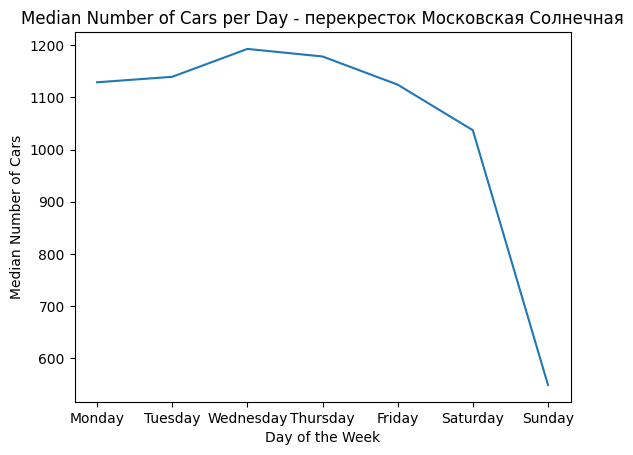

In [55]:
plot_median_cars_by_weekday(df, 'перекресток Московская Солнечная')

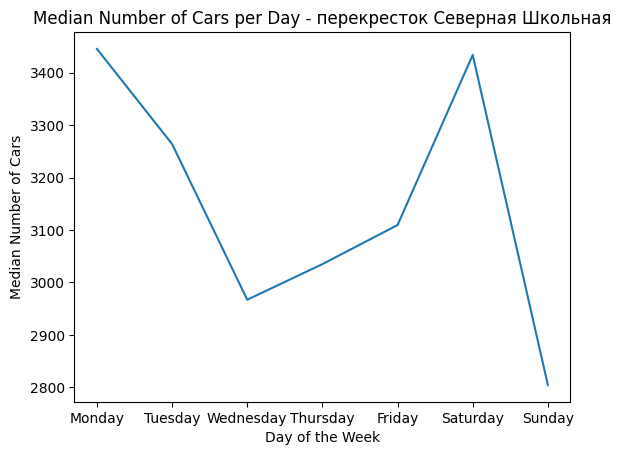

In [56]:
plot_median_cars_by_weekday(df, 'перекресток Северная Школьная')

In [112]:
import pandas as pd

def assign_category(num_cars):
    if num_cars < 500:
        return "<500"
    elif num_cars < 1000:
        return "500-1000"
    elif num_cars < 2500:
        return "1000-2500"
    elif num_cars < 5000:
        return "2500-5000"
    elif num_cars < 10000:
        return "5000-10000"
    elif num_cars < 15000:
        return "10000-15000"
    else:
        return ">15000"

# Calculate average number of cars per month for each street
df['Month'] = df['date'].dt.month
df_avg_cars_per_month = df.groupby(['street', 'Month'])['num_cars_daily'].mean().reset_index()

# Assign category based on average number of cars
df_avg_cars_per_month['Category'] = df_avg_cars_per_month['num_cars_daily'].apply(assign_category)

# Define color mapping for categories
color_mapping = {
    "<500": "background-color: lightblue",
    "500-1000": "background-color: lightgreen",
    "1000-2500": "background-color: green",
    "2500-5000": "background-color: red",
    "5000-10000": "background-color: pink",
    "10000-15000": "background-color: lightpink",
    ">15000": "background-color: orange"
}

# Apply color mapping to the 'Category' column
styled_df = df_avg_cars_per_month.style.applymap(lambda x: color_mapping.get(x, ''), subset=['Category'])

display(styled_df)


,street,Month,num_cars_daily,Category
0,перекресток Красная Северная,1,1586.806452,1000-2500
1,перекресток Красная Северная,2,1601.000000,1000-2500
2,перекресток Красная Северная,3,1472.870968,1000-2500
3,перекресток Красная Северная,4,1587.833333,1000-2500
4,перекресток Красная Северная,5,1711.870968,1000-2500
5,перекресток Красная Северная,6,1795.250000,1000-2500
6,перекресток Московская Солнечная,1,1059.612903,1000-2500
7,перекресток Московская Солнечная,2,1047.714286,1000-2500
8,перекресток Московская Солнечная,3,1050.354839,1000-2500
9,перекресток Московская Солнечная,4,1072.200000,1000-2500


In [113]:
def check_category_change(df, street):
    street_data = df[df['street'] == street].copy()
    prev_category = None
    message = ""

    for _, row in street_data.iterrows():
        category = row['Category']
        if prev_category is not None and category != prev_category:
            message = f"{street} has a change of category from the previous month."
            break
        prev_category = category

    if message:
        print(message)
    else:
        print(f"{street} does not have a change of category from the previous month.")


# Usage example
for street in df['street'].unique():
    check_category_change(df_avg_cars_per_month, street)


перекресток Красная Северная does not have a change of category from the previous month.
перекресток Московская Солнечная does not have a change of category from the previous month.
перекресток Северная Школьная has a change of category from the previous month.


#Выводы детектируем изменение на уселине трафика

In [115]:
!pip install folium

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 739.1 kB/s eta 0:00:00 kB/s eta 0:00:01


In [118]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Maps")
place = "Краснодар"
geo_loc = geolocator.geocode(place)
location = [geo_loc.latitude, geo_loc.longitude]

In [120]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Maps")
place = "Краснодар, ул. Красная, д.1"
geo_loc = geolocator.geocode(place)
location = [geo_loc.latitude, geo_loc.longitude]

[45.05331445, 39.003027698661576]


In [121]:
location

[45.22045355, 37.596834078976784]

## Обучение 1й модели на разных улицах

#### Импорты

In [222]:
from geopy.geocoders import Nominatim
import numpy as np
import pandas as pd


In [144]:

geolocator = Nominatim(user_agent="Maps")
place_1 = "Краснодар, ул Северная, 70" #перекресток Школьная Северная
geo_loc = geolocator.geocode(place_1)
location_1 = [geo_loc.latitude, geo_loc.longitude]
print(location_1)


geolocator = Nominatim(user_agent="Maps")
place_2 = "Краснодар, ул. Московская улица 79/7" #перекресток Московская Солнечная
geo_loc = geolocator.geocode(place_2)
location_2 = [geo_loc.latitude, geo_loc.longitude]
print(location_2)


geolocator = Nominatim(user_agent="Maps")
place_3 = "Краснодар, ул.Красная 127" #перекресток Красная Севрная
geo_loc = geolocator.geocode(place_3)
location_3 = [geo_loc.latitude, geo_loc.longitude]
print(location_3)

[45.045901799999996, 38.93860158420101]
[45.0724409, 39.0004805]
[45.22045355, 37.596834078976784]


In [154]:

# Set the desired date range
start_date = '2023-01-01'
end_date = '2023-06-16'

# Generate a date range with hourly frequency
date_range = pd.date_range(start=start_date, end=end_date, freq='H')

# Generate data with higher car counts during peak hours on working days
data = {
    'date': date_range,
    'number_of_cars': [
        np.random.randint(50, 100) if ((date.hour in range(7, 10) or date.hour in range(17, 20)) and date.weekday() < 6) else np.random.randint(0, 50)
        for date in date_range
    ]
}

df = pd.DataFrame(data)

# Convert the 'date' column to datetime index
df.set_index('date', inplace=True)

# Add place, latitude, and longitude for each street
places = [
    "Краснодар, ул Северная, 70",  # перекресток Школьная Северная
    "Краснодар, ул. Московская улица 79/7",  # перекресток Московская Солнечная
    "Краснодар, ул.Красная 127"  # перекресток Красная Севрная
]

latitudes = [location_1[0], location_2[0], location_3[0]]  # Replace latitude_1, latitude_2, and latitude_3 with actual latitude values
longitudes = [location_1[1], location_2[1], location_3[1]]  # Replace longitude_1, longitude_2, and longitude_3 with actual longitude values


display(df)
df['place'] = places
df['latitude'] = latitudes
df['longitude'] = longitudes

print(df.head())


,number_of_cars
date,
2023-01-01 00:00:00,33
2023-01-01 01:00:00,28
2023-01-01 02:00:00,23
2023-01-01 03:00:00,15
2023-01-01 04:00:00,27
...,...
2023-06-15 20:00:00,15
2023-06-15 21:00:00,36
2023-06-15 22:00:00,23


ValueError: Length of values (3) does not match length of index (3985)

In [160]:


# Set the desired date range
start_date = '2023-01-01'
end_date = '2023-06-16'

# Generate a date range with hourly frequency
date_range = pd.date_range(start=start_date, end=end_date, freq='H')


# Generate data with higher car counts during peak hours on working days
data = {
    'date': date_range,
    'number_of_cars': [
        np.random.randint(50, 100) if ((date.hour  in range(7,10) or date.hour in range (17,20)) and date.weekday() <6) else np.random.randint(0, 50)
        for date in date_range
    ]
}

df = pd.DataFrame(data)

# Convert the 'date' column to datetime index
df.set_index('date', inplace=True)


df['temperature'] = [generate_temperature(date) for date in df.index]

df['latitude'] = location_1[0]
df['longitude']  = location_1[1]
df['street'] = "Краснодар, ул Северная, 70"


In [161]:
df

,number_of_cars,temperature,latitude,longitude,street
date,,,,,
2023-01-01 00:00:00,48,9,45.045902,38.938602,"Краснодар, ул Северная, 70"
2023-01-01 01:00:00,18,2,45.045902,38.938602,"Краснодар, ул Северная, 70"
2023-01-01 02:00:00,35,2,45.045902,38.938602,"Краснодар, ул Северная, 70"
2023-01-01 03:00:00,8,8,45.045902,38.938602,"Краснодар, ул Северная, 70"
2023-01-01 04:00:00,38,-3,45.045902,38.938602,"Краснодар, ул Северная, 70"
...,...,...,...,...,...
2023-06-15 20:00:00,6,5,45.045902,38.938602,"Краснодар, ул Северная, 70"
2023-06-15 21:00:00,19,14,45.045902,38.938602,"Краснодар, ул Северная, 70"
2023-06-15 22:00:00,36,18,45.045902,38.938602,"Краснодар, ул Северная, 70"


In [198]:
import numpy as np
import pandas as pd

# Set the desired date range
start_date = '2023-01-01'
end_date = '2023-06-16'

# Generate a date range with hourly frequency
date_range = pd.date_range(start=start_date, end=end_date, freq='H')

# Generate data with higher car counts during peak hours on working days
data = {
    'date': date_range,
    'number_of_cars': [
        np.random.randint(50, 100) if ((date.hour in range(7, 10) or date.hour in range(17, 20)) and date.weekday() < 6) else np.random.randint(0, 50)
        for date in date_range
    ]
}

df_1 = pd.DataFrame(data)

# Convert the 'date' column to datetime index
df_1.set_index('date', inplace=True)


def generate_temperature(date):
    # Custom function to generate temperature based on date
    # Replace with your own logic to generate temperature
    return np.random.randint(0, 50)


df_1['temperature'] = [generate_temperature(date) for date in df_1.index]


df_1['latitude'] = location_1[0]
df_1['longitude'] = location_1[1]
df_1['street'] = "Краснодар, ул Северная, 70"

# Copy the DataFrame
df_2 = df_1.copy()


df_2['latitude'] = location_2[0]
df_2['longitude'] = location_2[1]
df_2['street'] = "Краснодар, ул. Московская улица 79/7"
multiplier = np.random.uniform(1.5, 1.9)

# Multiply the 'number_of_cars' column by the random multiplier
df_2['number_of_cars'] = round(df_2['number_of_cars'] * multiplier).astype(int)



df_3 = df_1.copy()


df_3['latitude'] = location_3[0]
df_3['longitude'] = location_3[1]
df_3['street'] = "Краснодар, ул.Красная 127"
multiplier = np.random.uniform(0.5, 0.9)

# Multiply the 'number_of_cars' column by the random multiplier
df_3['number_of_cars'] = round(df_3['number_of_cars'] * multiplier).astype(int)



display(df_1.head())
display(df_2.head())
display(df_3.head())


,number_of_cars,temperature,latitude,longitude,street
date,,,,,
2023-01-01 00:00:00,5,48,45.045902,38.938602,"Краснодар, ул Северная, 70"
2023-01-01 01:00:00,15,44,45.045902,38.938602,"Краснодар, ул Северная, 70"
2023-01-01 02:00:00,47,44,45.045902,38.938602,"Краснодар, ул Северная, 70"
2023-01-01 03:00:00,0,42,45.045902,38.938602,"Краснодар, ул Северная, 70"
2023-01-01 04:00:00,18,1,45.045902,38.938602,"Краснодар, ул Северная, 70"


,number_of_cars,temperature,latitude,longitude,street
date,,,,,
2023-01-01 00:00:00,9,48,45.072441,39.000481,"Краснодар, ул. Московская улица 79/7"
2023-01-01 01:00:00,26,44,45.072441,39.000481,"Краснодар, ул. Московская улица 79/7"
2023-01-01 02:00:00,81,44,45.072441,39.000481,"Краснодар, ул. Московская улица 79/7"
2023-01-01 03:00:00,0,42,45.072441,39.000481,"Краснодар, ул. Московская улица 79/7"
2023-01-01 04:00:00,31,1,45.072441,39.000481,"Краснодар, ул. Московская улица 79/7"


,number_of_cars,temperature,latitude,longitude,street
date,,,,,
2023-01-01 00:00:00,4,48,45.220454,37.596834,"Краснодар, ул.Красная 127"
2023-01-01 01:00:00,12,44,45.220454,37.596834,"Краснодар, ул.Красная 127"
2023-01-01 02:00:00,36,44,45.220454,37.596834,"Краснодар, ул.Красная 127"
2023-01-01 03:00:00,0,42,45.220454,37.596834,"Краснодар, ул.Красная 127"
2023-01-01 04:00:00,14,1,45.220454,37.596834,"Краснодар, ул.Красная 127"


In [224]:
combined_df.to_csv('training_data.csv')

In [207]:
import pandas as pd

# Combine the three datasets into one
combined_df = pd.concat([df_1, df_2, df_3])

# Reset the index of the combined DataFrame
# combined_df.reset_index(inplace=True)

# Display the combined DataFrame
display(combined_df.head())


,number_of_cars,temperature,latitude,longitude,street
date,,,,,
2023-01-01 00:00:00,5,48,45.045902,38.938602,"Краснодар, ул Северная, 70"
2023-01-01 01:00:00,15,44,45.045902,38.938602,"Краснодар, ул Северная, 70"
2023-01-01 02:00:00,47,44,45.045902,38.938602,"Краснодар, ул Северная, 70"
2023-01-01 03:00:00,0,42,45.045902,38.938602,"Краснодар, ул Северная, 70"
2023-01-01 04:00:00,18,1,45.045902,38.938602,"Краснодар, ул Северная, 70"


In [208]:
combined_df['street'].value_counts()
combined_df['street'] = combined_df['street'].astype('category')

In [183]:
tscv = TimeSeriesSplit(n_splits=5)
scoring_metric='neg_mean_squared_error'

In [187]:
combined_df.set_index('date', inplace=True)

In [206]:
combined_df

,date,number_of_cars,temperature,latitude,longitude,street
0,2023-01-01 00:00:00,5,48,45.045902,38.938602,"Краснодар, ул Северная, 70"
1,2023-01-01 01:00:00,15,44,45.045902,38.938602,"Краснодар, ул Северная, 70"
2,2023-01-01 02:00:00,47,44,45.045902,38.938602,"Краснодар, ул Северная, 70"
3,2023-01-01 03:00:00,0,42,45.045902,38.938602,"Краснодар, ул Северная, 70"
4,2023-01-01 04:00:00,18,1,45.045902,38.938602,"Краснодар, ул Северная, 70"
...,...,...,...,...,...,...
11950,2023-06-15 20:00:00,8,25,45.220454,37.596834,"Краснодар, ул.Красная 127"
11951,2023-06-15 21:00:00,38,29,45.220454,37.596834,"Краснодар, ул.Красная 127"
11952,2023-06-15 22:00:00,30,3,45.220454,37.596834,"Краснодар, ул.Красная 127"
11953,2023-06-15 23:00:00,26,42,45.220454,37.596834,"Краснодар, ул.Красная 127"


In [209]:


best_rmse = 60
lag = 0
window = 0

for i in range(5, 100, 5):
    for k in range(2, 50, 5):
        data = combined_df.copy(deep=True)
        make_features(data, i, k)
        data = data.dropna()
        target = data['number_of_cars']
        features = data.drop(['number_of_cars'], axis=1)
        
        model_lgbm = lgb.LGBMRegressor()
        scores = cross_val_score(model_lgbm, features, target, cv=tscv, scoring=scoring_metric)
        rmse = np.sqrt(np.abs(np.mean(scores)))
        
        if rmse < best_rmse:
            best_rmse = rmse
            lag = i
            window = k

print('Best RMSE:', best_rmse)
print('Lag:', lag)
print('Window:', window)

Best RMSE: 25.96830153570203
Lag: 5
Window: 2


In [212]:
data = combined_df.copy(deep=True)
make_features(data, lag, window)
data = data.dropna()
target = data[['number_of_cars']]
features = data.drop(['number_of_cars'], axis=1)
model_lgbm = lgb.LGBMRegressor()
model_lgbm.fit(features,target)

LGBMRegressor()

In [221]:

with open('traffic_forecast_model', 'wb') as f:
    pickle.dump(model_lgbm, f)



### Предсказания

In [197]:
combined_df

,number_of_cars,temperature,latitude,longitude,street
date,,,,,
2023-01-01 00:00:00,38,21,45.045902,45.072441,"Краснодар, ул Северная, 70"
2023-01-01 01:00:00,44,17,45.045902,45.072441,"Краснодар, ул Северная, 70"
2023-01-01 02:00:00,38,6,45.045902,45.072441,"Краснодар, ул Северная, 70"
2023-01-01 03:00:00,14,21,45.045902,45.072441,"Краснодар, ул Северная, 70"
2023-01-01 04:00:00,2,47,45.045902,45.072441,"Краснодар, ул Северная, 70"
...,...,...,...,...,...
2023-06-15 20:00:00,39,27,45.220454,37.596834,"Краснодар, ул.Красная 127"
2023-06-15 21:00:00,14,49,45.220454,37.596834,"Краснодар, ул.Красная 127"
2023-06-15 22:00:00,12,32,45.220454,37.596834,"Краснодар, ул.Красная 127"


In [196]:
import numpy as np
import pandas as pd

# Set the random seed for reproducibility
np.random.seed(0)

# Generate random temperatures
temperatures = np.random.randint(10, 30, size=24)

# Create a DataFrame with the generated temperatures
data = pd.DataFrame({
    'temperature': temperatures
}, index=pd.date_range('2024-07-02 00:00:00', periods=24, freq='H'))

# Convert the index to datetime format
data.index = pd.to_datetime(data.index)

# Add additional columns for street, latitude, and longitude
data['latitude'] = [45.045902, 45.045902, 45.072441, 45.072441]
data['longitude'] = [45.072441, 45.072441, 39.000481, 39.000481]
data['street'] = ['Краснодар, ул Северная, 70', 'Краснодар, ул Северная, 70', 'Краснодар, ул. Московская улица 79/7', 'Краснодар, ул. Московская улица 79/7']

# Add additional time-related features
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek

# Drop the 'number_of_cars' column from the new data
features = data.drop(['temperature'], axis=1)

# Make predictions using your trained model
predictions = model_lgbm.predict(features)

# Add the predictions to the data DataFrame
data['predictions'] = predictions

# Display the generated dataset
display(data)


ValueError: Length of values (4) does not match length of index (24)

In [ ]:


np.random.seed(0)
temperatures = np.random.randint(10, 30, size=24)

# Create a DataFrame with the generated temperatures
data = pd.DataFrame({
    'temperature': temperatures
}, index=pd.date_range('2024-07-02 00:00:00', periods=24, freq='H'))

# Convert the index to datetime format
data.index = pd.to_datetime(data.index)

data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek

# Make predictions using your trained model

# Drop the 'number_of_cars' column from the new data
features = data

# Make predictions using your trained model
predictions = model_lgbm.predict(features)

# Add the predictions to the data DataFrame
data['predictions'] = predictions

data

In [214]:
import numpy as np
import pandas as pd

# Create a DataFrame with the desired structure
data = pd.DataFrame({
    'date': ['2023-08-01 18:00:00', '2023-08-01 18:00:00', '2023-08-01 18:00:00', '2023-08-02 11:00:00', '2023-08-02 11:00:00', '2023-08-02 11:00:00'],
    'temperature': [21, 21, 21, 19, 19, 19],
    'latitude': [45.045902, 45.072441, 45.220454, 45.045902, 45.072441, 45.220454],
    'longitude': [38.93860158420101, 39.000481, 37.596834, 38.93860158420101, 39.000481, 37.596834],
    'street': ['Краснодар, ул Северная, 70', 'Краснодар, ул. Московская улица 79/7', 'Краснодар, ул.Красная 127',
               'Краснодар, ул Северная, 70', 'Краснодар, ул. Московская улица 79/7', 'Краснодар, ул.Красная 127']
})

# Convert the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Set the 'date' column as the index
data.set_index('date', inplace=True)

# Display the generated dataset
display(data)


,temperature,latitude,longitude,street
date,,,,
2023-08-01 18:00:00,21,45.045902,38.938602,"Краснодар, ул Северная, 70"
2023-08-01 18:00:00,21,45.072441,39.000481,"Краснодар, ул. Московская улица 79/7"
2023-08-01 18:00:00,21,45.220454,37.596834,"Краснодар, ул.Красная 127"
2023-08-02 11:00:00,19,45.045902,38.938602,"Краснодар, ул Северная, 70"
2023-08-02 11:00:00,19,45.072441,39.000481,"Краснодар, ул. Московская улица 79/7"
2023-08-02 11:00:00,19,45.220454,37.596834,"Краснодар, ул.Красная 127"


In [218]:
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek

cat_columns=['year','month','day','hour','dayofweek','street']
for col in cat_columns:
    data[col]=data[col].astype('category')

# Drop the 'number_of_cars' column from the new data
features = data

# Make predictions using your trained model
predictions = model_lgbm.predict(features)

# Add the predictions to the data DataFrame
data['predictions'] = predictions

# Display the generated dataset
display(data)

,temperature,latitude,longitude,street,year,month,day,hour,dayofweek,predictions
date,,,,,,,,,,
2023-08-01 18:00:00,21,45.045902,38.938602,"Краснодар, ул Северная, 70",2023,8,1,18,1,76.483161
2023-08-01 18:00:00,21,45.072441,39.000481,"Краснодар, ул. Московская улица 79/7",2023,8,1,18,1,131.847718
2023-08-01 18:00:00,21,45.220454,37.596834,"Краснодар, ул.Красная 127",2023,8,1,18,1,59.401196
2023-08-02 11:00:00,19,45.045902,38.938602,"Краснодар, ул Северная, 70",2023,8,2,11,2,18.199726
2023-08-02 11:00:00,19,45.072441,39.000481,"Краснодар, ул. Московская улица 79/7",2023,8,2,11,2,30.297642
2023-08-02 11:00:00,19,45.220454,37.596834,"Краснодар, ул.Красная 127",2023,8,2,11,2,15.074500
